# Processing annotated variant files

The script will process each annotated variant file and output the processed file along with several summary statistics

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg

/home/gway/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
filter_common_maf = 0.05
filter_min_depth_count = 10
filter_max_depth_count = 800

In [4]:
# Define a class that will process all of these outputs
class process_variants():
    """
    Takes as input a file name and has internal methods to process and output summary statistics
    for annotated variant call files
    """
    def __init__(self, variant_file, filter_min_depth=10, filter_max_depth=800,
                 filter_common_maf=0.05):
        self.variant_file = variant_file
        self.sample_name = os.path.basename(self.variant_file).split('.')[0]
        self.filter_min_depth = filter_min_depth
        self.filter_max_depth = filter_max_depth
        self.filter_common_maf = filter_common_maf
        self.variant_df = pd.read_csv(self.variant_file)
        self.all_variant_count = self.variant_df.shape[0]
        
    def _process_depth(self):
        other_info_list = self.variant_df['Otherinfo'].str.split('\t').tolist()
        depth_info_df = pd.DataFrame(other_info_list, columns=['het', 'quality', 'depth'])
        self.variant_df.index = depth_info_df.index
        self.variant_df = pd.concat([self.variant_df, depth_info_df], axis=1)
    
    def filter_depth(self):
        # Filter min depth
        self._process_depth()
        self.variant_df = self.variant_df[self.variant_df['depth'].astype(int) >= self.filter_min_depth]
        self.filter_min_depth_count = self.variant_df.shape[0]
        
        # Filter max depth
        self.variant_df = self.variant_df[self.variant_df['depth'].astype(int) <= self.filter_max_depth]
        self.filter_max_depth_count = self.variant_df.shape[0]
        
    def filter_common_variation(self):
        # Filter common variation
        unknown_freq_df = self.variant_df[self.variant_df['gnomAD_exome_ALL'] == '.']
        other_freq_df = self.variant_df[self.variant_df['gnomAD_exome_ALL'] != '.']
        self.unknown_maf_count = unknown_freq_df.shape[0]
       
        # Filter common variants
        other_freq_df = other_freq_df[other_freq_df['gnomAD_exome_ALL'].astype(float) <= 0.05]
        self.variant_df = pd.concat([other_freq_df, unknown_freq_df], axis=0)
        self.filter_common_var_count = self.variant_df.shape[0]
        
        # Get log 10 total mutation count
        self.log_mut_count = np.log10(self.filter_common_var_count)
        
    def plot_depth(self):
        sns.set(font_scale=1.5)
        sns.set_style('whitegrid')
        g = sns.distplot(self.variant_df['depth'].astype(float))
        g.set_title('Read Depth Distribution for {}'.format(self.sample_name))
    
    def summary_statistics(self):
        self.functional_counts = pd.DataFrame(self.variant_df['Func.refGene'].value_counts())
        self.functional_counts.columns = [self.sample_name]
        self.mutational_class_counts= pd.DataFrame(self.variant_df['ExonicFunc.refGene'].value_counts())
        self.mutational_class_counts.columns = [self.sample_name]
        
        # Get number of COSMIC curated events
        cosmic_filtered = self.variant_df[self.variant_df['cosmic70'] != '.']
        self.cosmic_variant_counts = cosmic_filtered.shape[0]
        
        # Get depth summary
        self.depth_summary = pd.DataFrame(self.variant_df['depth'].astype(int).describe())
        self.depth_summary.columns = [self.sample_name]

    def curate_filter_info(self):
        filter_list = [self.sample_name, self.all_variant_count, self.filter_min_depth_count,
                       self.filter_max_depth_count, self.filter_common_var_count, self.log_mut_count,
                       self.cosmic_variant_counts]
        return filter_list
    
    def curate_summary_info(self):
        return self.functional_counts, self.mutational_class_counts, self.depth_summary
    
    def output_processed_data(self, out_dir):
        processed_out_file = os.path.join(out_dir,
                                          '{}_processed_variants.tsv.bz2'.format(self.sample_name))
        self.variant_df.to_csv(processed_out_file, sep='\t', compression='bz2')
        

In [5]:
variant_file_path = os.path.join('results', 'annotated_vcfs')
processed_file_path = os.path.join('results', 'processed_vcfs')
filter_info_all = []
functional_counts_all = []
mutational_counts_all = []
depth_summary_all = []

for variant_file in os.listdir(variant_file_path):
    full_variant_file = os.path.join(variant_file_path, variant_file)
    
    variant_info = process_variants(full_variant_file)
    variant_info.filter_depth()
    variant_info.filter_common_variation()
    variant_info.summary_statistics()
    filter_info_all.append(variant_info.curate_filter_info())
    func_count, mut_count, depth_summary = variant_info.curate_summary_info()
    
    functional_counts_all.append(func_count)
    mutational_counts_all.append(mut_count)
    depth_summary_all.append(depth_summary)
    
    fig_file = os.path.join('figures', 'read_depth',
                            '{}_depth_distrib.pdf'.format(variant_info.sample_name))
    variant_info.plot_depth()
    plt.savefig(fig_file)
    plt.close()
    
    # Save processed output file
    variant_info.output_processed_data(out_dir=processed_file_path)

/home/gway/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
depth_output_file = os.path.join('results', 'full_depth_summary.tsv')
depth_df = pd.concat(depth_summary_all, axis=1).fillna(0).astype(int).T.sort_index()
depth_df.to_csv(depth_output_file, sep='\t')

In [7]:
mut_count_output_file = os.path.join('results', 'full_mutation_count_summary.tsv')
mutational_counts_df = pd.concat(mutational_counts_all, axis=1).fillna(0).astype(int).T.sort_index()
mutational_counts_df.to_csv(mut_count_output_file, sep='\t')

In [8]:
func_count_output_file = os.path.join('results', 'full_functional_count_summary.tsv')
functional_counts_df = pd.concat(functional_counts_all, axis=1).fillna(0).astype(int).T.sort_index()
functional_counts_df.to_csv(func_count_output_file, sep='\t')

In [9]:
filter_count_output_file = os.path.join('results', 'full_filter_summary.tsv')
filter_counts_df = pd.DataFrame(filter_info_all,
                                columns=['sample_name', 'all_variant_count',
                                         'filter_min_depth_count', 'filter_max_depth_count',
                                         'filter_common_var_count','log_mut_count',
                                         'COSMIC_count']).sort_values(by='sample_name')
filter_counts_df.to_csv(filter_count_output_file, sep='\t', index=False)

In [10]:
filter_counts_df = (
    filter_counts_df
    .assign(base_sample = [x[0] for x in filter_counts_df['sample_name'].str.split('_')])
    )
filter_counts_df = filter_counts_df.assign(lane = [x[2] for x in filter_counts_df['sample_name'].str.split('_')])

In [11]:
filter_counts_df['log_mut_count'] = round(filter_counts_df['log_mut_count'], 2)

In [14]:
filter_melt_df = (
    filter_counts_df.melt(id_vars=['base_sample', 'lane', 'sample_name', 'log_mut_count', 'COSMIC_count'],
                          value_vars=['all_variant_count', 'filter_min_depth_count',
                                      'filter_max_depth_count', 'filter_common_var_count'],
                          var_name='num_variants', value_name='filtration')
    )
filter_melt_df.sort_values(by='filtration')
filter_melt_df.head()

,base_sample,lane,sample_name,log_mut_count,COSMIC_count,num_variants,filtration
0,001-F0,L001,001-F0_S3_L001_001,4.00,67,all_variant_count,70284
1,001-F0,L002,001-F0_S3_L002_001,3.98,55,all_variant_count,68463
2,001-F0,L003,001-F0_S3_L003_001,4.00,72,all_variant_count,70585
3,001-F0,L004,001-F0_S3_L004_001,3.98,68,all_variant_count,68144
4,001-F5,L001,001-F5_S2_L001_001,3.98,64,all_variant_count,69586


## Visualize summary statistics across samples

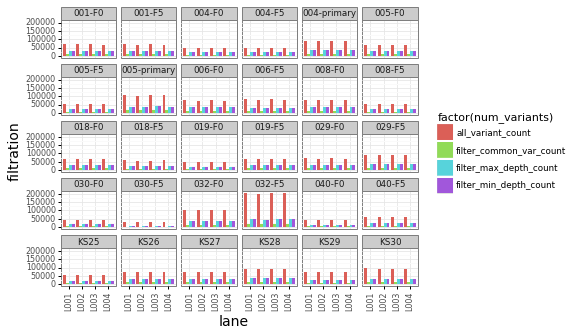

<ggplot: (8738438505080)>

In [15]:
p = (
    gg.ggplot(filter_melt_df,
              gg.aes(x='lane', y='filtration', fill='factor(num_variants)')) +
    gg.geom_bar(stat='identity', position='dodge') +
    gg.facet_wrap('~ base_sample') +
    gg.theme_bw() +
    gg.theme(axis_text_x=gg.element_text(angle='90'),
             axis_text=gg.element_text(size=8),
             axis_title=gg.element_text(size=14))
    )
p

In [16]:
figure_file = os.path.join('figures', 'filtration_results.pdf')
gg.ggsave(p, figure_file, height=5.5, width=6.5, dpi=500)

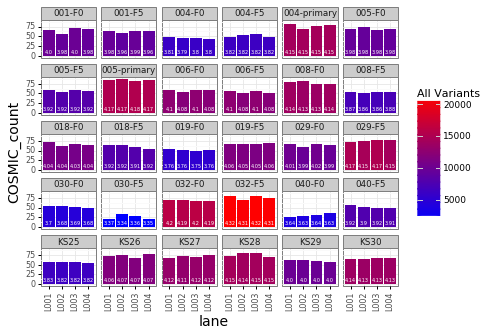

<ggplot: (8738438558973)>

In [17]:
p = (
    gg.ggplot(filter_counts_df,
              gg.aes(x='lane', y='COSMIC_count', fill='filter_common_var_count')) +
    gg.geom_bar(stat='identity', position='dodge') +
    gg.geom_text(gg.aes(y=10, label='log_mut_count'), size=5, colour='white') +
    gg.scale_fill_gradient(low='blue', high='red', name='All Variants') + 
    gg.facet_wrap('~ base_sample') +
    gg.theme_bw() +
    gg.theme(axis_text_x=gg.element_text(angle='90'),
             axis_text=gg.element_text(size=8),
             axis_title=gg.element_text(size=14))
    )
p

In [18]:
figure_file = os.path.join('figures', 'cosmic_mutcount_results.pdf')
gg.ggsave(p, figure_file, height=5.5, width=6.5, dpi=500)